# Exercise 1 Checkerboard task

## Requirements
- python >= 3.5
- tensorflow >= 2.0

## Constants, Imports

In [0]:
# ==============================================================================
# Constants, Imports
# ==============================================================================
# ------------------------------------------------------------------------------
# constants
COMET_EXPERIMENT = False
NOTEBOOK = True
TASK_SELECTION = "V" # "II", "IVa", "IVb", "V" (see 'train model')

In [0]:
# ------------------------------------------------------------------------------
# for notebook (eg google colab) only needed if comet_ml not installed yet
if COMET_EXPERIMENT and NOTEBOOK:
    %pip install comet_ml
# if installed for first time, restart notebook now

In [0]:
# ------------------------------------------------------------------------------
# setup comet experiment

# import comet_ml in the top of your file
if COMET_EXPERIMENT:
  from comet_ml import Experiment
    
  # Add the following code anywhere in your machine learning file
  experiment = Experiment(api_key="E7YQLfWBuQZXjw0c2dKsXKPsY",
                          project_name="exercise1", workspace="irratzo")
  
def myprint(string : str = ""):
  print(string)
  if COMET_EXPERIMENT:
    experiment.log_text(string)

In [0]:
# ------------------------------------------------------------------------------
"""
Exercise 1: Checkerboard task (TensorFlow version)
In this task the data consists of 2D vectors (x1, x2) uniformly sampled in the range (-1, 1).
The data samples are classified as signal y = 1 if either x1 or x2 > 0 (but not both).
The task is to train a simple neural network to correctly classify the data.
For now we formulate this problem as regression task with the network predicting a single value y_model and the optimizer minimizing the mean squared error between model and data.
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import collections # for class Task

## Setup model

In [0]:
# ==============================================================================
# Setup model
# ==============================================================================

# ------------------------------------------------------------------------------
# setup model
class Model(object):
    def __init__(self, nodes_per_layer : list =[2, 4, 1],
                 activation_functions : list = [tf.nn.relu, tf.sigmoid]):
        self.depth = len(nodes_per_layer) - 1
        self.nodes_per_layer = nodes_per_layer.copy()
        self.activation_functions = activation_functions.copy()

        if (len(self.activation_functions) != self.depth):
          raise ValueError("Number of activation functions ", \
                           len(activation_functions), "doesn't match " \
                           "network depth ",len(self.weights))        

        # create hidden layers
        self.weights = []
        self.biases = []

        # create hidden layers
        random_normal = tf.initializers.RandomNormal()
        npl = self.nodes_per_layer
        for layer in range(self.depth):
          self.weights.append(tf.Variable(random_normal([npl[layer], npl[layer+1]])))
          self.biases.append(tf.Variable(tf.zeros(npl[layer+1])))

    def __call__(self, x):        
        # walk through layers
        h = self.activation_functions[0](x @ self.weights[0] + self.biases[0])
        for i in range(1,self.depth):
          h = self.activation_functions[i](h @ self.weights[i] + self.biases[i])
        return h

In [0]:
# ------------------------------------------------------------------------------
# define loss: mean squared error
def objective(x, y):
    return tf.reduce_mean(tf.square(y - x))

# accuracy (= fraction of correct predictions)
def accuracy(x, y):
    correct_prediction = tf.equal(y, tf.round(x))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train model

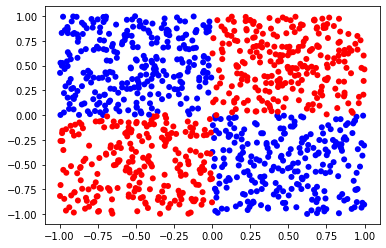

In [0]:
# ==============================================================================
# Train model
# ==============================================================================

# ------------------------------------------------------------------------------
# create training data
np.random.seed(1337)  # for reproducibility
# x = (x1, x2) with random numbers x1, x2 ~ Uniform(-1, 1)
# y ~ XOR(x1, x2)
N = 1000
lr = 0.05  # learning rate
xdata = (2 * np.random.rand(N, 2) - 1).astype(np.float32)   # shape = (N, 2)
ydata = (xdata[:, 0] * xdata[:, 1]) < 0  # shape = (N)
ydata = ydata.reshape(N, 1)            # shape = (N, 1)

# plot data
fig, ax = plt.subplots(1)
colors = ['blue' if y else 'red' for y in ydata]  # 'blue' for y=1 and 'red' for y=0
ax.scatter(*xdata.T, c=colors, lw=0)

In [0]:
# ------------------------------------------------------------------------------
# train your model

# first declare exercise1 tasks
Task = collections.namedtuple('Task',['nodes_per_layer',
                                      'activation_functions',
                                      'iterations'])
tasks = {    
    "II" : Task([2,4,1], [tf.nn.relu, tf.sigmoid], 20000),
    "IVa" : Task([2,8,1], [tf.nn.relu, tf.sigmoid],20000),
    "IVb" : Task([2,2,1], [tf.nn.relu, tf.sigmoid],20000),
    "V" : Task([2,4,4,1], [tf.nn.relu, tf.nn.relu, tf.sigmoid], 20000)
}
task = tasks[TASK_SELECTION]
myprint("Training model for Task 1.{}:\n{}".format(TASK_SELECTION,task))

tf.GradientTape().gradient
model = Model(nodes_per_layer=task.nodes_per_layer, 
              activation_functions=task.activation_functions)

for i in range(task.iterations+1):

    with tf.GradientTape() as tape:

        # foward pass
        current_loss = objective(model(xdata), ydata)
        acc = accuracy(model(xdata), ydata)
        if COMET_EXPERIMENT and (i%10==0): # prevent comet rate limit
            experiment.log_metric("loss", current_loss)  # log metric to comet
            experiment.log_metric("accuracy", acc)  # log metric to comet

        if i % 200 == 0:
            print("iteration:", i, "loss", current_loss, "accuracy", acc)

        # backward pass
        dTheta = \
        tape.gradient(current_loss, model.weights + model.biases)
        dWeights = dTheta[0 : model.depth]
        dBiases = dTheta[model.depth : ]
        for i in range(model.depth):
          model.weights[i].assign_sub(lr * dWeights[i])
          model.biases[i].assign_sub(lr * dBiases[i])

Training model for Task 1.II:
Task(nodes_per_layer=[2, 4, 1], activation_functions=[<function relu at 0x7fb7fcd4a2f0>, <function sigmoid at 0x7fb7fccf86a8>], iterations=5000)
iteration: 0 loss tf.Tensor(0.25001806, shape=(), dtype=float32) accuracy tf.Tensor(0.641, shape=(), dtype=float32)
iteration: 200 loss tf.Tensor(0.24919419, shape=(), dtype=float32) accuracy tf.Tensor(0.523, shape=(), dtype=float32)
iteration: 400 loss tf.Tensor(0.24872123, shape=(), dtype=float32) accuracy tf.Tensor(0.523, shape=(), dtype=float32)
iteration: 600 loss tf.Tensor(0.2480762, shape=(), dtype=float32) accuracy tf.Tensor(0.523, shape=(), dtype=float32)
iteration: 800 loss tf.Tensor(0.24696867, shape=(), dtype=float32) accuracy tf.Tensor(0.523, shape=(), dtype=float32)
iteration: 1000 loss tf.Tensor(0.2450158, shape=(), dtype=float32) accuracy tf.Tensor(0.523, shape=(), dtype=float32)
iteration: 1200 loss tf.Tensor(0.24160507, shape=(), dtype=float32) accuracy tf.Tensor(0.523, shape=(), dtype=float32)
i

In [0]:
# ------------------------------------------------------------------------------
#
# TODO: Verify TensorFlow by computing the network output and loss using pure numpy.
#   You can retrieve the weights and biases using
#   W1_, b1_, W2_, b2_ = sess.run([W1, b1, W2, b2])
#   Bonus: Don't look over the data.
#

# task1.III.: Verify model
def numpy_activation_function(tensorflow_activation_function):
    """
    Supported activation types: 'relu', 'sigmoid'.
    """
    def relu(h):
      return h.clip(min=0)
    def sigmoid(h):
      return 1./(1.+np.exp(-h))

    if tensorflow_activation_function == tf.nn.relu:
        return relu
    elif tensorflow_activation_function == tf.sigmoid:
        return sigmoid
    else:
        raise NotImplementedError("Supported activation types: 'tf.nn.relu', 'tf.sigmoid'.")

for i in range(model.depth):
    np_af = numpy_activation_function(model.activation_functions[i])
    np_W = model.weights[i].numpy()
    np_b = model.biases[i].numpy()
    x = xdata if (i==0) else y_numpy
    y_numpy = np_af(x @ np_W + np_b)
loss_numpy = np.mean(np.square(ydata - y_numpy))
myprint("manually calculated loss: {:.8f}".format(loss_numpy))
myprint("difference to tensorflow loss: {:.2e}".format(abs(current_loss - loss_numpy)))

manually calculated loss: 0.11146261
difference to tensorflow loss: 3.51e-06


## Now use the trained network

In [0]:
# ==============================================================================
# Evaluation on a test dataset
# ==============================================================================

# ------------------------------------------------------------------------------
# Compute the model prediction on a grid of 500 x 500 points
n = 500
s = np.linspace(-1, 1, n).astype(np.float32)
xp = np.array(np.meshgrid(s, s))    # xp.shape = (2, 500, 500), all combinations of s with s
xp = xp.T                           # xp.shape = (500, 500, 2)
xp = xp.reshape((-1, 2))            # xp.shape = (500*500, 2), reshape
yp = model(xp)                      # yp.shape = (500*500, 1), model prediction
yp = np.array(yp)                   # convert to numpy array
yp = yp.reshape((n, n))             # yp.shape = (500, 500), reshape

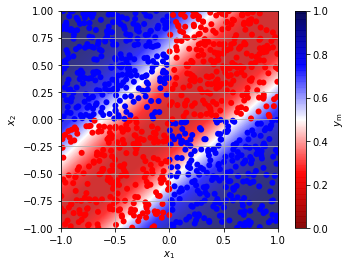

In [0]:
# ------------------------------------------------------------------------------
# plot model prediction
fig, ax = plt.subplots(1)
im = ax.imshow(yp, extent=(-1, 1, -1, 1), origin='lower',
               vmin=0, vmax=1, cmap=plt.cm.seismic_r, alpha=0.8)
cbar = plt.colorbar(im)
cbar.set_label('$y_\mathrm{m}$')

# plot data
colors = ['blue' if y else 'red' for y in ydata]  # 'blue' for y=1 and 'red' for y=0
ax.scatter(*xdata.T, c=colors, lw=0)

ax.set(xlabel='$x_1$', ylabel='$x_2$', aspect='equal')
ax.grid(True)
fig.savefig('checkerboard.png', bbox_inches='tight')
if COMET_EXPERIMENT:
  experiment.log_image('checkerboard.png')

In [0]:
# end experiment after all outputs done
if COMET_EXPERIMENT:
  experiment.end()